---
title: "Theory of RL V: Temporal-Difference Learning"
date: "2021-05-13"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

Like Monte Carlo (MC) methods, temporal difference (TD) learning methods learn from experience without needing a model of the environment's dynamics. However, unlike MC methods, TD learning methods can learn from *incomplete* sequences and thus can be used in continuing environments. Let's look at this in more detail.

As we have discussed in the last post, MC methods can only update their value estimates at the end of an episode since they rely on actual returns $G_t = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{T-1} R_T$ which can only be computed from complete trajectories. These actual returns $G_t$ are unbiased estimates of the true value function $v_{\pi}(s)$, but they are also of high variance because they accumulate the inherent randomness of all transitions in an entire episode (recall that all actions, next states, and rewards are random events). This is why MC methods can be slow and sample inefficient (i.e. we need lots of data to see the signal in the noise). TD learning methods, in contrast, leverage the recursive relationship $V(S_t) = R_{t+1} + \gamma V(S_{t+1})$ to *estimate* the return and conduct updates **online**. That is, TD learning methods **bootstrap**: in their updates they rely in part on existing estimates instead of exclusively requiring actual rewards. It follows that the TD target has **low variance** (it only accumulates the randomness of a single transition) at the cost of **some bias**. We'll see below how this plays out.

In [5]:
import numpy as np
import matplotlib as plt
from itertools import count
import gym
import gym_walk

## TD Prediction

Naturally, we'll begin by considering the problem of estimating the value function $v_{\pi}$ for a given policy $\pi$. As was mentioned above, the key characteristic of TD methods is that they estimate $v_{\pi}$ using an estimate of $v_{\pi}$. But how? With one-step TD, n-step TD, and TD($\lambda$) we'll introduce different methods for TD prediction.

### TD(0)

TD(0) is the simplest TD learning algorithm. It is also called **one-step TD** since it updates after a single step $S_t, A_t, R_{t+1}, S_{t+1} \sim \pi$ in the environment, that is, immediately after observing the next state $S_{t+1}$ and receiving the reward $R_{t+1}$. Essentially, the algorithm fully exploits the Markov property. Its update looks like this:

$$V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right],$$

where $R_{t+1} + \gamma V(S_{t+1})$ is the **TD target** and $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is the **TD error**. What happens here? Well, TD(0) estimates the return at each step by summing the *actual* reward $R_{t+1}$ and the discounted *estimate* of the value of the next state $\gamma V(S_{t+1})$. The rest of the update should be clear. We compute the TD error and take a small step (defined by the step-size parameter $\alpha$) in its direction. If $\sum_{t=1}^{\infty} \alpha_t = \infty$ and $\sum_{t=1}^{\infty} \alpha_t^2 < \infty$, TD(0) is guaranteed to converge to $v_{\pi}$.

In [6]:
def decay(decay_ratio, start_val, min_val, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (start_val - min_val) * values + min_val
    values = np.pad(values, (0, max_steps - decay_steps), 'edge')
    return values

In [7]:
#| code-fold: show

def td(env, pi, gamma=1., n_episodes=500, start_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5):
    n_states = env.observation_space.n
    value = np.zeros(n_states)
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = pi[state]
            next_state, reward, done, _ = env.step(action)
            
            value_next = value[next_state] if not done else 0.
            value[state] += alphas[ep] * ((reward + gamma * value_next) - value[state])
            #td_target = reward + gamma * value[next_state] * (not done)
            #td_error = td_target - value[state]
            #value[state] = value[state] + alphas[ep] * td_error
            
            state = next_state
    
    return value

In [8]:
env = gym.make("RandomWalkFive-v0")
pi = {state : 0 for state in range(env.prob.shape[0])}
td_val = td(env, pi)

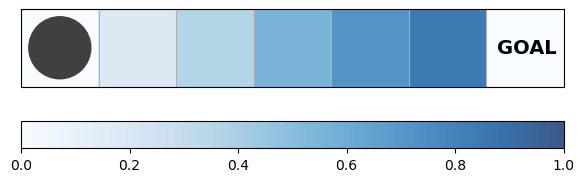

In [9]:
env.render(values=td_val)

In [13]:
env = gym.make("FrozenLake4x4-v2")
pi = [1 for _ in range(16)]
td_val = td(env, pi)

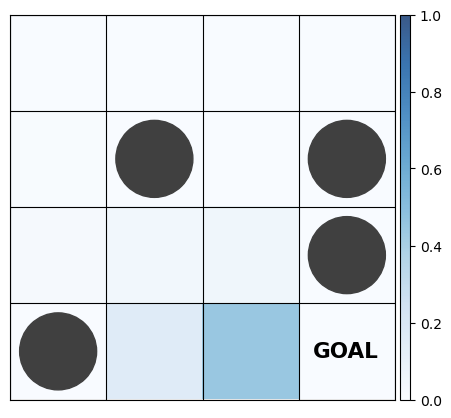

In [12]:
env.render(values=td_val)

### $n$-step TD Learning

With MC and TD(0) we now have introduced two rather extreme approaches, each having its own advantages. While MC methods update each state based on the entire sequence of actual rewards received from that state until the end of the episode, TD(0) updates are merely based on the next reward, using the current estimate of the next state's value as a proxy for the remaining rewards. You are not mistaken if you reckon that there must exist a range of algorithms in between those extremes. Indeed, we could perform a two-step update based on the first two rewards and the estimated value of the subsequent state. Similary, we could perform three-step updates, four-step updates, and so on. $n$-step TD learning is a generalization of this idea. With an intermediate value for $n$ it often performs better than either TD(0) and MC.

Suppose we want to update the estimated value of state $S_t$ based on the state-reward sequence $S_t, R_{t+1}, S_{t+1}, R_{t+2}, S_{t+2}, \dots, R_T, S_T$. In TD(0), the target would be the **one-step return** $G_{t:t+1}$:

$$G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1}),$$

where $V_t$ is the estimate of $v_{\pi}$ at time $t$ and the subscripts on $G_{t:t+1}$ indicate that, to estimate the return at time $t$, we use actual rewards up until time $t{+}1$ and the discounted estimate $\gamma V_t(S_{t+1})$ to correct for the absence of the other terms $\gamma R_{t+1} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1}R_T$.

A two-step update would simply use the **two-step return** as a target:

$$G_{t:t+2} = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2}),$$

where we use $\gamma^2 V_{t+1}(S_{t+2})$ as a proxy for the terms $\gamma^2 R_{t+3} + \gamma^3 R_{t+4} + \dots + \gamma^{T-t-1} R_T$.

Accordingly, we can perform an n-step update using the $n$**-step return** as our target:

$$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n}),$$

for all $n, t$ such that $n \geq 1$ and $0 \leq t < T - n$. If $t+n \geq T$, the $n$-step return would be equal to the complete return, meaning that we would effectively perform an MC update. 

The update of the **n-step TD** algorithm looks like this:

$$V_{t+n}(S_t) \leftarrow V_{t+n-1}(S_t) + \alpha \left[ G_{t:t+n} - V_{t+n-1}(S_t) \right]$$

Note that no update can occur until $R_{t+n}$ is known, i.e. the updates set in at time step $t+n$ and multiple updates are conducted when the episode has terminated (the updates are catching up in a sense). 

In [14]:
#| code-fold: show

def n_step_td(env, 
              pi, 
              n_step=3, 
              gamma=1., 
              n_episodes=500, 
              start_alpha=0.5, 
              min_alpha=0.01, 
              alpha_decay_ratio=0.5):
    n_states = env.observation_space.n
    value = np.zeros(n_states)
    discounts = np.power(gamma, np.arange(n_step+1))
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        trajectory = []
        
        while not done or trajectory is not None:
            trajectory = trajectory[1:]
        
            while not done and len(trajectory) < n_step:
                action = pi[state]
                next_state, reward, done, _ = env.step(action)
                trajectory.append((state, reward, next_state, done))
                state = next_state
                if done:
                    break
        
            n = len(trajectory)
            state_ = trajectory[0][0]
            G = discounts[:n] * np.array(trajectory)[:, 1]
            value_next = value[next_state] if not done else 0.
            ntd_target = np.sum(np.append(G, discounts[-1] * value_next))
            value[state_] += alphas[ep] * (ntd_target - value[state_])
            
            if trajectory[0][3] and len(trajectory) == 1:
                trajectory = None
    
    return value

In [19]:
ntd_val = n_step_td(env, pi, n_step=3)

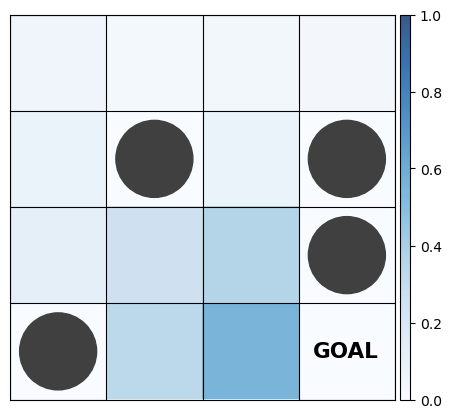

In [20]:
env.render(values=ntd_val)

### TD($\lambda$)

Inevitably, the question arises which $n$ we should choose to obtain the best results. But instead of choosing a particular $n$, we can take the concept of TD learning one step further by combining multiple $n$-steps into a single update. One particular way of doing this is the $\lambda$-return which is discussed below. We'll first put it to use in the forward-view TD($\lambda$) algorithm which updates the state-value estimates with a weighted combination of all $n$-step targets at the end of an episode. Then, we'll introduce eligibility traces and the more elegant backward-view TD($\lambda$) algorithm which can perform partial updates at each step.

#### The $\lambda$-return

In the last section we introduced the $n$-step return, defined as the sum of the first $n$ rewards plus the estimated value of the state reached in $n$ steps (each properly discounted):

$$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})$$

To improve on this we can use the average of $n$-step returns for different $n$ instead of choosing a specific $n$. The $\lambda$-return, in particular, **averages all the $n$-step updates**, each weighted proportionally to $\lambda^{n-1}$ (where $\lambda \in [0,1])$ and normalized by a factor of $1-\lambda$ so that the weights sum to $1$. The resulting formula for the $\lambda$-return looks like this:

$$G_t^{\lambda} = (1-\lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1} G_{t:t+n} + \lambda^{T-t-1} G_{t:T} = (1 - \lambda) \sum_{n=1}^{\infty} \lambda^{n-1} G_{t:t+n}$$

The one-step return receives the largest weight, $1-\lambda$, the two-step return receives the next largest weight, $(1-\lambda)\lambda$, and so on. This goes on for all $n$-steps until a terminal state is reached. Then the $n$-step return is equal to the ordinary return $G_t$ and weighted by $\lambda^{T-t-1}$:

$$
\begin{align}
    G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1}) & \qquad \text{is weighted by}\;\; (1 - \lambda) \\
    G_{t:t+2} = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2}) & \qquad \text{is weighted by}\;\; (1 - \lambda)\lambda \\
    G_{t:t+3} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 V_{t+2}(S_{t+3}) & \qquad \text{is weighted by}\;\; (1 - \lambda)\lambda^2 \\
    G_{t:t+n} = R_{t+1} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1} (S_{t+n}) & \qquad \text{is weighted by}\;\; (1 - \lambda)\lambda^{n-1} \\
    G_{t:T} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{T-1} R_T & \qquad \text{is weighted by}\;\; \lambda^{T-t-1}
\end{align}
$$

When looking at the formula it should become clear that the $\lambda$-return offers a spectrum of methods spanning from one-step TD ($\lambda=0$) to MC ($\lambda=1$), where methods in between often perform better than both extremes.

#### forward-view TD($\lambda$)

Forward-view TD($\lambda$) is the simplest learning algorithm applying the $\lambda$-return. Its update looks like this:

$$V_T(S_t) = V_{T-1}(S_t) + \alpha_t \left[ G_{t:T}^{\lambda} - V_{T-1}(S_t) \right],$$

where $G_{t:T}^{\lambda}$ is the $\lambda$-return and $G_{t:T}^{\lambda} - V_{T-1}(S_t)$ is the $\lambda$-error. Its problem, however, is that the algorithm like MC methods has to wait until the end of an episode before it can make updates to the value function estimates. Fortunately, researchers have developed backward-view TD($\lambda$), a more sophisticated method that can apply partial updates on every time step.

#### Eligibility traces and backward-view TD($\lambda$)

Backward-view TD($\lambda$), or simply **TD($\lambda$)** for short, uses **eligibility traces to determine if, and by how much, a state is eligible for an update**. An eligibility trace is a **memory vector** that tracks the recently visited states. Let's walk through the process to see how the algorithm works. 

In the beginning, all eligibility traces are initialized to zero:

$$E_0(s) = 0, \quad \forall s \in \mathcal{S}$$

When the agent has interacted with the environment for one cycle $S_t, A_t, R_{t+1}, S_{t+1} \sim \pi_{t:t+1}$, we increment the eligibility of state $S_t$ by $1$

$$E_t(S_t) = E_t(S_t) + 1$$

and calculate the **TD error**

$$\delta_{t} = R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)$$

in order to perform the following update:

$$V_{t+1}(s) = V_t(s) + \alpha_t \delta_{t}E_t(s), \quad \forall s \in \mathcal{S}$$

By multiplying the update for all states by the eligibility trace $E$ we ensure that each state is updated according to its respective eligibility. 

Finally, we decay the eligibility trace vector by $\lambda$ (the same $\lambda$ as introduced with the $\lambda$-return, also called the **trace-decay parameter**) and $\gamma$ (the discount factor) so that the traces fade away:

$$E_{t+1} = \gamma \lambda  E_t$$


In essence, TD($\lambda$) has three advantages:

* It is flexible since it spans methods from one-step TD to MC, depending on $\lambda$.
* It performs updates at every time step which is more computationally efficient.
* It makes sure that learning occurs continually and affects the behavior of the agent right away (i.e. immediately after a state is encountered).

In [24]:
#| code-fold: show

def td_lambda(env,
              pi,
              gamma=1., 
              lambda_ = 0.3,
              n_episodes=500, 
              start_alpha=0.5, 
              min_alpha=0.01, 
              alpha_decay_ratio=0.5):
    n_states = env.observation_space.n
    value = np.zeros(n_states)
    E = np.zeros(n_states)
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    
    for ep in range(n_episodes):
        E.fill(0)
        state = env.reset()
        done = False
        
        while not done:
            action = pi[state]
            next_state, reward, done, _ = env.step(action)
            value_next = value[next_state] if not done else 0.
            E[state] += 1
            value += alphas[ep] * ((reward + gamma * value[next_state]) - value[state]) * E
            E *= gamma * lambda_
            state = next_state
    
    return value

In [25]:
tdl_val = td_lambda(env, pi)

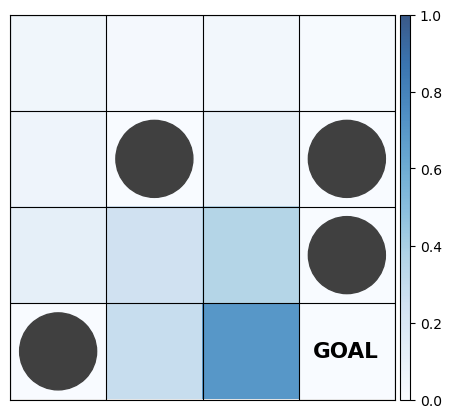

In [27]:
env.render(values=tdl_val)

## TD Control

To extend TD methods to the control problem, we once again draw on the pattern of generalized policy iteration (GPI). Recall that GPI consists of two interacting processes: predicting the value function of the current policy (for which we now use TD prediction) and improving the policy with respect to the current value function (where we have to deal with the exploration-exploitation trade-off). With this in mind, we distinguish two classes of methods. **On-policy methods** evaluate and improve the policy that is used to make decisions, which means that the agent has to seek the best policy that still accounts for exploration. **Off-policy methods**, on the other hand, separate both concerns by evaluating and improving a policy (the **target policy**) that is different from the one used to generate the behavior (the **behavior policy**). This is a more complex, but also a more powerful idea: since both policies can be unrelated, the behavior policy can keep sampling all possible actions while the agent learns a deterministic optimal policy.

We'll see both concepts in action when we introduce some of the classic RL algorithms below.

### Sarsa

Sarsa is an algorithm for **on-policy TD control**, that is, it estimates $q_{\pi}(s,a)$ for the current behavior policy $\pi$ and makes $\pi$ greedy with respect to $q_{\pi}$ (recall that we need to learn an action-value function instead of a state-value function to know which actions to take). Thus, to apply the TD method, we need to look at the transition from one state-action pair to the next. The corresponding sequence $S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}$ gives rise to the algorithm's name: Sarsa. Its update, performed after every transition from a nonterminal state $S_t$, uses every element of this sequence:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]$$

Sarsa converges to an optimal policy if all state-action pairs are visited infinitely often and the policy converges in the limit to the greedy policy (again, this is referred to as being Greedy in the Limit with Infinite Exploration, GLIE). 

In [28]:
#| code-fold: show

def sarsa(env, 
          gamma=1., 
          n_episodes=5000, 
          start_eps=1., 
          min_eps=0.1, 
          eps_decay_ratio=0.9, 
          start_alpha=0.5, 
          min_alpha=0.01, 
          alpha_decay_ratio=0.5):
    
    n_states, n_actions = env.observation_space.n, env.action_space.n
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    epsilons = decay(eps_decay_ratio, start_eps, min_eps, n_episodes)
    
    q = np.zeros((n_states, n_actions))
    pi = lambda state, q, epsilon: np.argmax(q[state]) if np.random.random() > epsilon else np.random.randint(len(q[state]))
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        action = pi(state, q, epsilons[ep])
        
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = pi(next_state, q, epsilons[ep])
            q_next = q[next_state][next_action] if not done else 0.
            td_target = reward + gamma * q_next
            q[state][action] += alphas[ep] * (td_target - q[state][action])
            state, action = next_state, next_action
        
    value = np.max(q, axis=1)
    pi = {state: action for state, action in enumerate(np.argmax(q, axis=1))}
    return value, pi

In [56]:
sarsa_val, sarsa_pi = sarsa(env, n_episodes=5000)

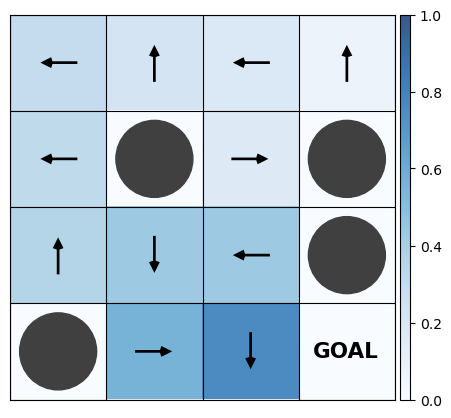

In [57]:
env.render(policy=sarsa_pi, values=sarsa_val)

### Sarsa($\lambda$)

The original version of Sarsa, discussed above, is also referred to as one-step Sarsa or Sarsa(0) because it uses the one-step TD target. Correspondingly, Sarsa can be combined with the $n$-step return to obtain $n$-step Sarsa, and with the $\lambda$-return to obtain Sarsa($\lambda$). Here, we skip $n$-step Sarsa und turn our attention to the more powerful Sarsa($\lambda$) algorithm right away.

The key idea of Sarsa($\lambda$) is to use the TD($\lambda$) prediction method for state-action pairs rather than states. Therefore, we need an eligibility matrix to track each state-action pair instead of an eligibility vector that merely tracks states. Apart from that the method equals TD($\lambda$). We begin by initializing each eligibility trace to zero

$$E_0(s,a) = 0, \quad \forall s \in \mathcal{S}, a \in \mathcal{A}(s)$$

When the agent has interacted with the environment for one sequence $S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1} \sim \pi$, we increment the eligibility of the state-action pair $S_t, A_t$ by $1$

$$E_t(S_t, A_t) = E_t(S_t, A_t) + 1,$$

calculate the error

$$\delta_t = R_{t+1} + \gamma Q_t(S_{t+1}, A_{t+1}) - Q_t(S_t, A_t)$$

and apply the update for every state $s$ and action $a$:

$$Q(s,a) \leftarrow Q(s,a) + \alpha_t \delta_t E_t(s,a), \quad \forall s \in \mathcal{S}, a \in \mathcal{A} $$

Finally, we decay the eligibility traces:

$$E_{t+1}(s,a) = \gamma \lambda E_t(s,a), \quad \forall s \in \mathcal{S}, a \in \mathcal{A}$$

In [58]:
#| code-fold: show

def sarsa_lambda(env, 
                 gamma=1., 
                 n_episodes=5000, 
                 lambda_ = 0.5,
                 replacing_traces=True,
                 start_eps=1.,
                 min_eps=0.1, 
                 eps_decay_ratio=0.9, 
                 start_alpha=0.5, 
                 min_alpha=0.01, 
                 alpha_decay_ratio=0.5):
    
    n_states, n_actions = env.observation_space.n, env.action_space.n
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    epsilons = decay(eps_decay_ratio, start_eps, min_eps, n_episodes)
    
    q = np.zeros((n_states, n_actions))
    E = np.zeros((n_states, n_actions))
    pi = lambda state, q, epsilon: np.argmax(q[state]) if np.random.random() > epsilon else np.random.randint(len(q[state]))
    
    for ep in range(n_episodes):
        E.fill(0)
        state = env.reset()
        done = False
        action = pi(state, q, epsilons[ep])
        
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = pi(next_state, q, epsilons[ep])
            
            q_next = q[next_state][next_action] if not done else 0.
            td_target = reward + gamma * q_next
            if replacing_traces:
                E[state].fill(0)
            E[state][action] += 1
            if replacing_traces:
                E.clip(0, 1, out=E)
            q += alphas[ep] * (td_target - q[state][action]) * E
            E *= gamma * lambda_
            
            state, action = next_state, next_action
    
    value = np.max(q, axis=1)
    pi = {state: action for state, action in enumerate(np.argmax(q, axis=1))}
    return value, pi

In [59]:
sarsa_lambda_val, sarsa_lambda_pi = sarsa_lambda(env, n_episodes=5000)

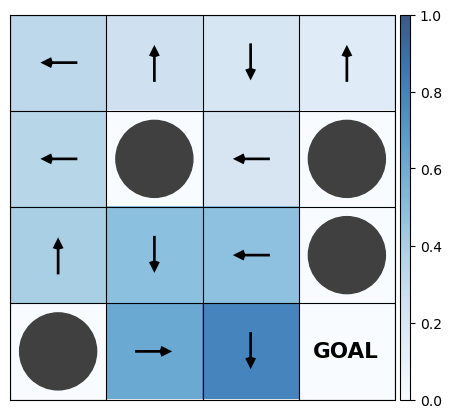

In [60]:
env.render(policy=sarsa_lambda_pi, values=sarsa_lambda_val)

### Q-learning

Unlike Sarsa, Q-learning is an **off-policy TD control** method. This means that the action-value function $Q$ (the one we learn) approximates the optimal action-value function $q_*$ independent of the policy being followed. For the convergence of the algorithm it is merely required that the behavior policy continues to visit all state-action pairs (this deserves no special attention since any method guaranteeing to find an optimal policy has this requirement).

Let's look at the update rule:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right]$$

We see that the Q-learning algorithm does *not* use the behavior policy to choose the action $A_{t+1}$ used in its target. Instead it uses the action with maximum best estimated value (it is not relevant which action this is). Hence, the algorithm is able to find an optimal policy even if the agent acts randomly.

In [46]:
#| code-fold: show

def q_learning(env,
               gamma=1.,
               n_episodes=5000,
               start_eps=1.,
               min_eps=0.1,
               eps_decay_ratio=0.9,
               start_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    epsilons = decay(eps_decay_ratio, start_eps, min_eps, n_episodes)
    q = np.zeros((n_states, n_actions))
    draw_action = lambda state, q, epsilon: np.argmax(q[state]) if np.random.random() > epsilon else np.random.randint(len(q[state]))
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = draw_action(state, q, epsilons[ep])
            next_state, reward, done, _ = env.step(action)
            q_next = np.max(q[next_state, :]) if not done else 0.
            td_target = reward + gamma * q_next
            q[state][action] += alphas[ep] * (td_target - q[state][action])
            state = next_state
        
    value = np.max(q, axis=1)
    pi = {state: action for state, action in enumerate(np.argmax(q, axis=1))}
    return value, pi

In [61]:
q_val, q_pi = q_learning(env, n_episodes=5000)

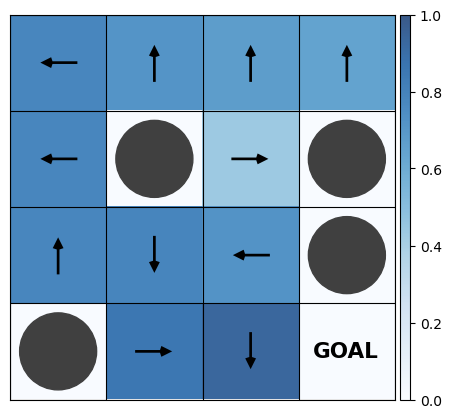

In [62]:
env.render(policy=q_pi, values=q_val)

### Double Q-learning

A problem with the Q-learning algorithm is that it overestimates the action-value function: on every step it uses a maximum over estimated values as an estimate of the true maximum action-value of the next state, resulting in what can be a substantial positive bias. To illustrate this, just imagine a state $s$ where five actions $a$ can be taken whose true values $q(s,a)$ are zero, but whose estimated values $Q(s,a)$ are uncertain and distributed around zero: $-0.33, 0.70, 0.05, -0.16, 0.48$. While the maximum of the true action-values is zero, the maximum of the estimates is always positive (here: $0.70$). This **maximization bias** is mitigated by an idea called **double learning**. In Double Q-learning, we keep **two separate estimates of the action-value function**, $Q_1$ and $Q_2$. At each time step, we randomly choose one of them to determine the action (the action with the highest estimated value), and the other one to provide the estimated value of that action. 

If we choose $Q_1$ to determine the action, the update is

$$ Q_1(S_t, A_t) \leftarrow Q_1(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q_{2}\left(S_{t+1}, \text{argmax}_a Q_1(S_{t+1}, a) \right) - Q_1(S_t, A_t) \right].$$

If we choose $Q_2$ to determine the action, we simply switch $Q_1$ and $Q_2$ to obtain the following update:

$$Q_2(S_t, A_t) \leftarrow Q_2(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q_1\left(S_{t+1}, \text{argmax}_a Q_2(S_{t+1}, a) \right) - Q_2(S_t, A_t) \right].$$

The behavior policy can use both estimates of the $Q$-function to interact with the environment (by using the average or the sum, for instance).

In [65]:
#| code-fold: show

def double_q_learning(env,
                      gamma=1.,
                      n_episodes=5000,
                      start_eps=1.,
                      min_eps=0.1,
                      eps_decay_ratio=0.9,
                      start_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.5
                      ):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    alphas = decay(alpha_decay_ratio, start_alpha, min_alpha, n_episodes)
    epsilons = decay(eps_decay_ratio, start_eps, min_eps, n_episodes)
    q1 = np.zeros((n_states, n_actions))
    q2 = np.zeros((n_states, n_actions))
    draw_action = lambda state, q, epsilon: np.argmax(q[state]) if np.random.random() > epsilon else np.random.randint(len(q[state]))
    
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = draw_action(state, (q1 + q2)/2, epsilons[ep])
            next_state, reward, done, _ = env.step(action)
            
            if np.random.randint(2):
                td_target = reward + gamma * q2[next_state][np.argmax(q1[next_state])] * (not done)
                q1[state][action] += alphas[ep] * (td_target - q1[state][action])
            else:
                td_target = reward + gamma * q1[next_state][np.argmax(q2[next_state])] * (not done)
                q2[state][action] += alphas[ep] * (td_target - q2[state][action])
            state = next_state
    
    q = (q1 + q2)/2
    value = np.max(q, axis=1)
    pi = {state: action for state, action in enumerate(np.argmax(q, axis=1))}
    return value, pi

In [71]:
env = gym.make("FrozenLake4x4-v2")
dq_val, dq_pi = double_q_learning(env, n_episodes=20000)

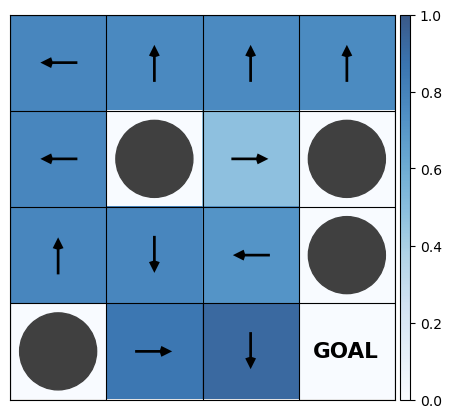

In [72]:
env.render(policy=dq_pi, values=dq_val)